In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [66]:
train_data, train_label = load_wine(return_X_y=True)

#### Keeping only the first two classes to create a binary problem as instructed
train_data = np.array(train_data[:(59+71)])
train_label = np.array(train_label[:(59+71)])

train_data = (train_data - train_data.mean(axis=0))/(train_data.max(axis=0)-train_data.min(axis=0))

In [67]:
logist_regr = LogisticRegression(solver='sag', penalty=None, max_iter=10000).fit(train_data, train_label)
ideal_loss = log_loss(train_label, logist_regr.predict_proba(train_data))

print(ideal_loss)

0.0002669798879851338


In [68]:
def steepest_coord_descent(tr_data, tr_label, weights, max_iter=100000, lr=0.01, random_feature=False, sparsity_k=-1):
    from scipy.special import expit
    loss_steepest_cd = []

    for iter in range(max_iter):
        zero_weight_ids = np.where(weights == 0)[0]
        zero_weight_ids = zero_weight_ids.astype(int)
        #print(zero_weight_ids.shape[0])
        #if(zero_weight_ids.shape[0] == sparsity_k):
        #    print('Sparsity K zeroes left')
        #pred = 1./(1. + np.exp(-1. * np.matmul(weights.T, train_data.T)))
        #wx = np.dot(weights.T, tr_data.T)
        #pred = 1./(1. + np.exp(-1. * np.dot(weights.T, tr_data.T)))
        pred = expit(np.dot(weights.T, tr_data.T))

        if(np.count_nonzero(pred) != pred.shape[0]):
            pred_ids = np.where(pred == 0)[0]
            pred_ids = pred_ids.astype(int)
            pred[pred_ids] = 1e-10
            pred_ids = np.where(pred == 1)[0]
            pred_ids = pred_ids.astype(int)
            pred[pred_ids] = 1-(1e-10)
        #print(pred)
        iter_loss = -(1./len(tr_data)) * np.sum(
            tr_label * np.log(pred) +
            (1 - tr_label) * np.log(1. - pred)
        )
        loss_steepest_cd.append(iter_loss)
        #print(iter_loss)

        #partial_grads = np.sum(np.matmul((pred - train_label), train_data), axis=0) / len(train_data)
        partial_grads = np.dot((pred - tr_label), tr_data)[0]
        #print(partial_grads)
        if(zero_weight_ids.shape[0] == sparsity_k):
            partial_grads[zero_weight_ids] = 0
        if(random_feature):
            update_coord = np.random.randint(0,len(partial_grads),1)[0]
        else:
            update_coord = np.argmax(np.abs(partial_grads))
        weights[update_coord] = weights[update_coord] - lr * partial_grads[update_coord]
        #print(weights[steepest_coord])

    #print(loss_steepest_cd[-1])
    return weights, loss_steepest_cd

In [69]:
weights = np.zeros([len(train_data[0]), 1])
lr = 0.2
max_iter = 100000
loss_steepest_cd = []


weights_steepest_cd, loss_steepest_cd = steepest_coord_descent(train_data, train_label, weights, max_iter, lr)
print("Steepest CD, final loss: ", loss_steepest_cd[-1])

weights = np.zeros([len(train_data[0]), 1])
#lr = 0.4
loss_rand_feature = []
weights_rand_feature, loss_rand_feature = steepest_coord_descent(train_data, train_label, weights, max_iter, lr, random_feature=True)
print("Random Feature CD, final loss: ", loss_rand_feature[-1])

Steepest CD, final loss:  0.00024433668162716416
Random Feature CD, final loss:  0.0004669984567036148


In [70]:
weights = np.zeros([len(train_data[0]), 1])
lr = 0.2
max_iter = 10000
loss_sparse_cd = [[]]
weights_sparse_cd = [[]]
sparsity_k = [2, 4, 6, 7, 8, 9, 10]
for i in range(len(sparsity_k)):
    weights = np.zeros([len(train_data[0]), 1])
    w, l = steepest_coord_descent(train_data, train_label, weights, max_iter, lr, sparsity_k=sparsity_k[i])
    weights_sparse_cd.append(w)
    loss_sparse_cd.append(l)
    
weights_sparse_cd = weights_sparse_cd[1:]
loss_sparse_cd = loss_sparse_cd[1:]

for i in range(len(sparsity_k)):
    print("Sparse CD, K=", sparsity_k[i], ", final loss: ", loss_sparse_cd[i][-1])
#print(loss_sparse_cd)
#print(weights_sparse_cd)

Sparse CD, K= 2 , final loss:  0.002044103808929562
Sparse CD, K= 4 , final loss:  0.002044103808929562
Sparse CD, K= 6 , final loss:  0.002082351140049844
Sparse CD, K= 7 , final loss:  0.020509449945060623
Sparse CD, K= 8 , final loss:  0.022910905557505613
Sparse CD, K= 9 , final loss:  0.039155214391965856
Sparse CD, K= 10 , final loss:  0.040477643473233384


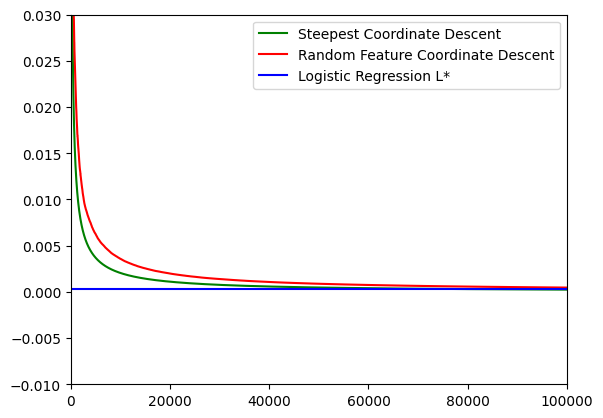

In [71]:
plt.figure()
plt.plot(loss_steepest_cd, 'g-', label='Steepest Coordinate Descent')
plt.plot(loss_rand_feature, 'r-', label='Random Feature Coordinate Descent')
plt.axhline(y=ideal_loss, color='b', label='Logistic Regression L*')
plt.xlim(0, len(loss_steepest_cd))
plt.ylim((-0.01, 0.03))
plt.legend()

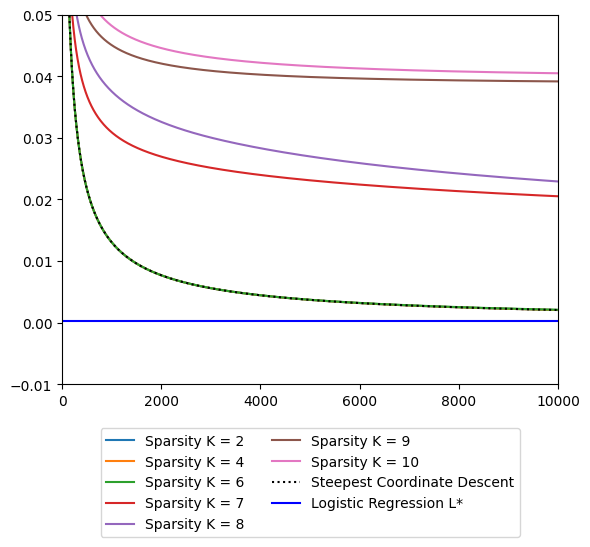

In [72]:
plt.figure()
ax = plt.subplot(111)
max_x = 10000
for i in range(len(sparsity_k)):
    ax.plot(loss_sparse_cd[i][:max_x], label='Sparsity K = '+str(sparsity_k[i]))
ax.plot(loss_steepest_cd[:max_x], 'k:', label='Steepest Coordinate Descent')
#plt.plot(loss_rand_feature, 'r-', label='Random Feature Coordinate Descent')
ax.axhline(y=ideal_loss, color='b', label='Logistic Regression L*')
plt.xlim(0, max_x)
plt.ylim((-0.01, 0.05))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=2, fancybox=True, shadow=False)
#plt.legend()
plt.show()